# Multimodal RAG Based Product Recommendation System
## Proof of Concept

### Imports

In [1]:
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt
import os
import uuid
import requests
from chromadb import Client
import pandas

### Initializing 

This section sets up a persistent vector database and configures a collection for multimodal data (text and images):

**Initializing Persistent Database:** A database is initialized to store data persistently at a specified file path, ensuring data durability.

**Defining an Image Loader:** A loader is set up to process and load image data efficiently.

**Setting up Multimodal Embedding Function:** An embedding function is configured to generate vector embeddings for both text and images.

**Creating or Retrieving a Database Collection:** A collection is created (or retrieved if it already exists) to store multimodal data. It integrates the embedding function and image loader.

In [2]:
chroma_client = chromadb.PersistentClient(path="./my_vectordb")
image_loader = ImageLoader()

multimodal_ef = OpenCLIPEmbeddingFunction()
multimodal_db = chroma_client.get_or_create_collection(name="multimodal_db", embedding_function=multimodal_ef, data_loader=image_loader)

d:\Codes\Python\bitirme\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"{multimodal_db.count()} record available.")

645 record available.


This method is designed to retrieve query results and present them both textually and visually using `matplotlib`

In [4]:
def print_query_results(query_list: list, query_results: dict)->None:
    result_count = len(query_results['ids'][0])

    for i in range(len(query_list)):
        print(f'Results for query: {query_list[i]}')

        for j in range(result_count):
            id = query_results["ids"][i][j]
            distance = query_results['distances'][i][j]
            data = query_results['data'][i][j]
            document = query_results['documents'][i][j]
            metadata = query_results['metadatas'][i][j]
            uri = query_results['uris'][i][j]

            print(f'id: {id}, distance: {distance}, metadata: {metadata}, document: {document}') 
            print(f'data: {uri}')
            plt.imshow(data)
            plt.axis("off")
            plt.show()

### Processing and Storing Product Images

This section handles downloading product images from URLs listed in a CSV file and storing them in the multimodal database:

- **Image Downloading**:  
  A utility function is defined to download images from provided URLs and save them locally. It ensures reliable downloading with error handling:  
  - The image is fetched via HTTP, and its content is saved to a specified file path.  
  - If the download fails, an error message is displayed, and the process moves on to the next image.  

- **Reading CSV Data**:  
  Product information, including image data, is extracted from a CSV file (`SHIRTS.csv`). The `Product_Image` column contains image URLs and related data. 
  (Previously, another data file named `JACKETS.csv` was processed using the same operations.) 

- **Image Processing**:  
  Each image entry is processed iteratively:  
  - Image metadata is evaluated to extract relevant details.  
  - The image name is sanitized by replacing spaces with underscores for file naming consistency.  
  - The processed image is saved locally in the `./images` directory.  

- **Adding to the Multimodal Database**:  
  After downloading an image, its information is stored in the multimodal database:  
  - Each image is assigned a unique ID using UUID.  
  - The image URI (relative file path), metadata (category, name, and unique identifier), and other attributes are added to the database collection.  

This workflow automates the process of downloading product images, organizing them locally, and storing their metadata for future retrieval and analysis.


In [5]:
def download_image(url, save_path):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        response = requests.get(url, headers=headers, stream=True)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"Image downloaded: {save_path}")
        return True
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False


In [6]:
df = pandas.read_csv('SHIRTS.csv')
products = df['Product_Image']

for p_data in products:
    data = eval(p_data)
    for _ in data:
        print(_)
        key = list(_.keys())[0]
        val = _[key]
        val = val.split(' ')
        val = "_".join(val)
        path = f'./images/{val}.png'
        if not download_image(key, path):
            continue
        unique_id = str(uuid.uuid4())
        multimodal_db.add(
            ids=[
                unique_id
            ],
            uris=[
                f'images/{val}.png'
            ],
            metadatas=[
                {"item_id":unique_id, 'img_category':'cloth', 'item_name':val}
            ]
        )

### Querying and Visualizing Results

In [7]:
def query(query_texts, category):
    query_results = multimodal_db.query(
        query_texts = query_texts,
        n_results=3,
        include=['documents', 'distances', 'metadatas', 'data', 'uris'],
        where={'img_category':f'{category}'}
    )

    print_query_results(query_texts, query_results)

Results for query: white black lined
id: 47e48f10-2cbc-45cb-a2fa-e34e9204826b, distance: 1.4605910778045654, metadata: {'img_category': 'cloth', 'item_id': '47e48f10-2cbc-45cb-a2fa-e34e9204826b', 'item_name': 'Image_0_of_ASYMMETRIC_SHIRT_WITH_STRIPES_from_Zara'}, document: None
data: images/Image_0_of_ASYMMETRIC_SHIRT_WITH_STRIPES_from_Zara.png


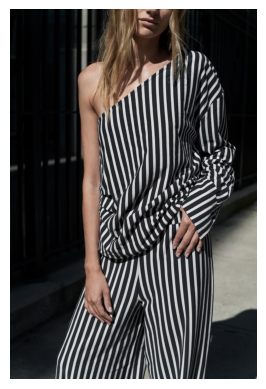

id: 003af582-7cc3-4058-b244-a8ee87db180d, distance: 1.4708664417266846, metadata: {'img_category': 'cloth', 'item_id': '003af582-7cc3-4058-b244-a8ee87db180d', 'item_name': 'Image_1_of_STRIPED_OVERSIZE_SHIRT_from_Zara'}, document: None
data: images/Image_1_of_STRIPED_OVERSIZE_SHIRT_from_Zara.png


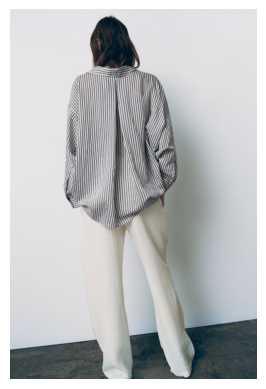

id: c4b42d52-c949-434b-8c37-e2c890c246fc, distance: 1.4712731838226318, metadata: {'img_category': 'cloth', 'item_id': 'c4b42d52-c949-434b-8c37-e2c890c246fc', 'item_name': 'Image_0_of_STRIPED_OVERSIZE_SHIRT_from_Zara'}, document: None
data: images/Image_0_of_STRIPED_OVERSIZE_SHIRT_from_Zara.png


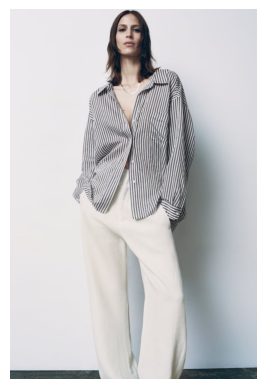

In [8]:
query(['white black lined'], 'cloth')

Results for query: purple jacket
id: 771e6e48-9ac5-4b9f-8dc4-75ab02e00e73, distance: 1.4756979942321777, metadata: {'img_category': 'cloth', 'item_id': '771e6e48-9ac5-4b9f-8dc4-75ab02e00e73', 'item_name': 'Image_0_of_PRINTED_TOP_WITH_GATHERED_DETAIL_from_Zara'}, document: None
data: images/Image_0_of_PRINTED_TOP_WITH_GATHERED_DETAIL_from_Zara.png


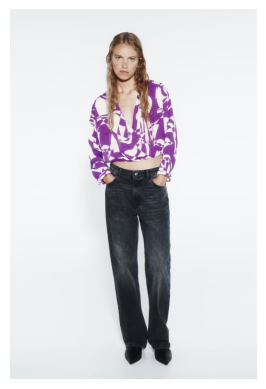

id: fb95bd3e-fc55-4a81-a6e9-15f8585ed7ec, distance: 1.4775094985961914, metadata: {'img_category': 'cloth', 'item_id': 'fb95bd3e-fc55-4a81-a6e9-15f8585ed7ec', 'item_name': 'Image_1_of_PRINTED_TOP_WITH_GATHERED_DETAIL_from_Zara'}, document: None
data: images/Image_1_of_PRINTED_TOP_WITH_GATHERED_DETAIL_from_Zara.png


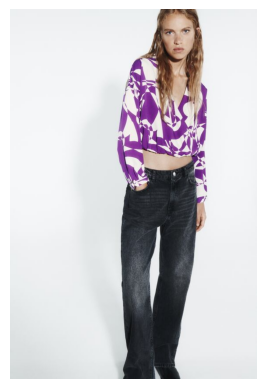

id: 8e955c70-bb22-4650-badd-8eb569a9e8b0, distance: 1.4860563278198242, metadata: {'img_category': 'cloth', 'item_id': '8e955c70-bb22-4650-badd-8eb569a9e8b0', 'item_name': 'Image_0_of_SATIN_TOP_WITH_KNOT_from_Zara'}, document: None
data: images/Image_0_of_SATIN_TOP_WITH_KNOT_from_Zara.png


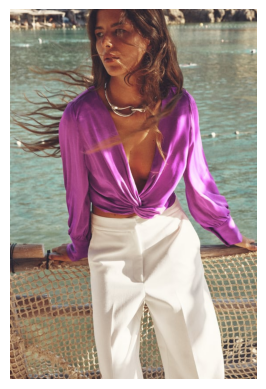

In [9]:
query(['purple jacket'], 'cloth')

Results for query: dark blue jacket
id: a5abf256-d367-46ff-aac0-2fb912c66288, distance: 1.3918685913085938, metadata: {'img_category': 'cloth', 'item_id': 'a5abf256-d367-46ff-aac0-2fb912c66288', 'item_name': 'Image_1_of_LINEN_BLEND_CROPPED_JACKET_from_Zara'}, document: None
data: images/Image_1_of_LINEN_BLEND_CROPPED_JACKET_from_Zara.png


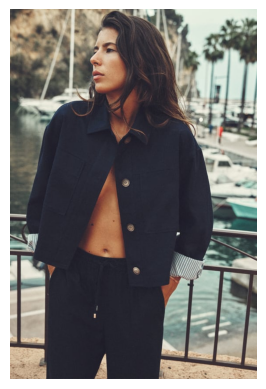

id: 890f3313-8162-4a69-b9d5-3ad807dd5339, distance: 1.4130322933197021, metadata: {'img_category': 'cloth', 'item_id': '890f3313-8162-4a69-b9d5-3ad807dd5339', 'item_name': 'Image_1_of_SHORT_DOUBLE-BREASTED_TRENCH_COAT_from_Zara'}, document: None
data: images/Image_1_of_SHORT_DOUBLE-BREASTED_TRENCH_COAT_from_Zara.png


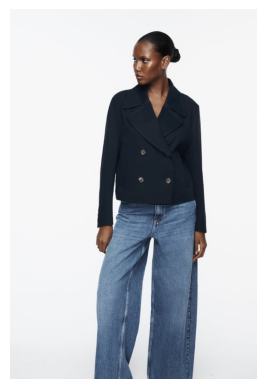

id: d3da3676-7580-4433-acfd-94ad33b6a46d, distance: 1.4362465143203735, metadata: {'img_category': 'cloth', 'item_id': 'd3da3676-7580-4433-acfd-94ad33b6a46d', 'item_name': 'Image_0_of_SHORT_DOUBLE-BREASTED_TRENCH_COAT_from_Zara'}, document: None
data: images/Image_0_of_SHORT_DOUBLE-BREASTED_TRENCH_COAT_from_Zara.png


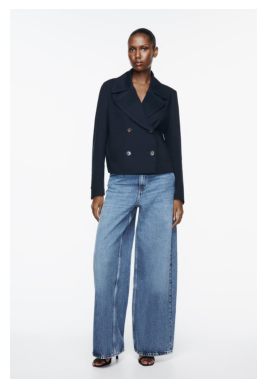

In [23]:
query(['dark blue jacket'], 'cloth')

Results for query: leather jacket
id: f5c38a33-06c3-4339-9850-7db23ebaca0b, distance: 1.386883020401001, metadata: {'img_category': 'cloth', 'item_id': 'f5c38a33-06c3-4339-9850-7db23ebaca0b', 'item_name': 'Image_1_of_CROPPED_FAUX_LEATHER_JACKET_from_Zara'}, document: None
data: images/Image_1_of_CROPPED_FAUX_LEATHER_JACKET_from_Zara.png


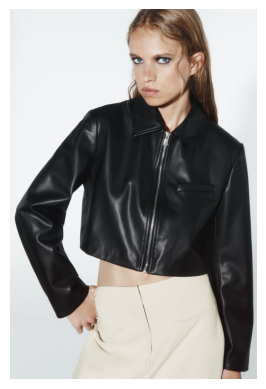

id: 5817ef35-69d9-471a-87b7-8f72d3e10abc, distance: 1.3907350301742554, metadata: {'img_category': 'cloth', 'item_id': '5817ef35-69d9-471a-87b7-8f72d3e10abc', 'item_name': 'Image_1_of_TRANSPARENT_CROPPED_JACKET_from_Zara'}, document: None
data: images/Image_1_of_TRANSPARENT_CROPPED_JACKET_from_Zara.png


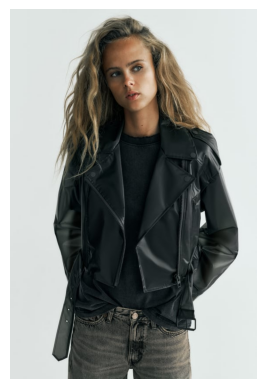

id: c2faf3d3-a53c-4929-98c2-4ae92757b6d5, distance: 1.396202564239502, metadata: {'img_category': 'cloth', 'item_id': 'c2faf3d3-a53c-4929-98c2-4ae92757b6d5', 'item_name': 'Image_1_of_FAUX_LEATHER_BIKER_JACKET_from_Zara'}, document: None
data: images/Image_1_of_FAUX_LEATHER_BIKER_JACKET_from_Zara.png


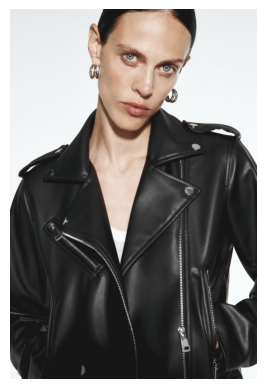

In [25]:
query(['leather jacket'], 'cloth')